# Multivairate Model

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
from __future__ import print_function, division, unicode_literals
# for python 2 and 3 compatibility
from builtins import str
try:
    from pathlib import Path
except:
    from pathlib2 import Path

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import numpy as np
from IPython.display import display
#--------------------------------------------
import sys
ppath = "../.."

if ppath not in sys.path:
    sys.path.append(ppath)
#--------------------------------------------
import pygeopressure as ppp

## 1. Calculate optimized multivariate model coefficients

Create survey with the example survey `CUG`:

In [2]:
# set to the directory on your computer
SURVEY_FOLDER = "C:/Users/yuhao/Desktop/CUG_depth"

survey = ppp.Survey(Path(SURVEY_FOLDER))

Retrieve well `CUG1`:

In [3]:
well_cug1 = survey.wells['CUG1']

Get Velocity, Shale volume and Porosity logs:

In [4]:
vel_log = well_cug1.get_log("Velocity")
por_log = well_cug1.get_log("Porosity")
vsh_log = well_cug1.get_log("Shale_Volume")

obp_log = well_cug1.get_log("Overburden_Pressure")

Calculate optimized multivariate model parameters:

In [5]:
a0, a1, a2, a3 = ppp.optimize_multivaraite(
    well=well_cug1, 
    obp_log=obp_log, 
    vel_log=vel_log,
    por_log=por_log, 
    vsh_log=vsh_log, 
    B=well_cug1.params['bowers']['B'],
    upper=1500, lower=3500)

View velocity, porosity, shale volume and effecive pressure used for optimization, and Velocity predicted by the optimized model (blue line):

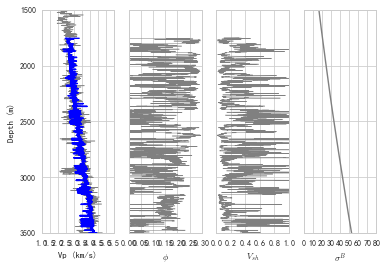

In [6]:
fig, axes = plt.subplots(ncols=4, nrows=1, sharey=True)
axes[0].invert_yaxis()

ppp.plot_multivariate(
    axes,
    well_cug1,
    vel_log, por_log, vsh_log, obp_log, 1500, 3500, a0, a1, a2, a3, 
    well_cug1.params['bowers']['B'])

## 2. Pressure Prediction with multivaraite model

Multivaraite pressure prediction:

In [7]:
pres_log = well_cug1.multivariate(vel_log, por_log, vsh_log)

Post-process predicted pressure:

In [8]:
pres_log_filter = ppp.upscale_log(pres_log, freq=20)

pres_log_filter_smooth = ppp.smooth_log(pres_log_filter, window=1501)

View predicted pressure:

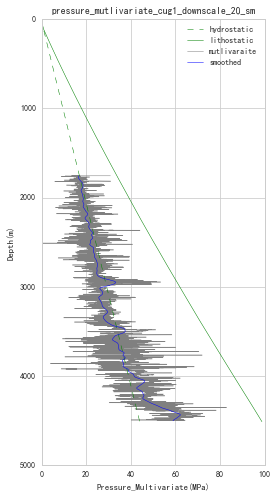

In [9]:
fig_pres, ax_pres = plt.subplots()
ax_pres.invert_yaxis()

well_cug1.hydro_log().plot(ax_pres, color='green', linestyle='--', 
                           zorder=2, label='hydrostatic')

well_cug1.get_log("Overburden_Pressure").plot(ax_pres, color='g', 
                                              label='lithostatic')

pres_log.plot(ax_pres, label='mutlivaraite', zorder=1)

pres_log_filter_smooth.plot(ax_pres, label='smoothed', zorder=5, color='b')

ax_pres.set(xlim=[0,100], ylim=[5000,0], aspect=(100/5000)*2)
ax_pres.legend()
fig_pres.set(figheight=8)
fig_pres.show()